In [1]:
# === Celda 1: Imports + CONFIG ===
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from dataclasses import dataclass

# Helpers (mismos que ya usas en Retail, o define versiones simples)
def _norm_col(c): 
    return (str(c).strip()
            .replace(" ", "_").replace("-", "_").replace(".", "_")
            .replace("(", "").replace(")", "")
            .lower())

def _to_datetime(s): 
    return pd.to_datetime(s, errors="coerce", utc=False)

def _to_numeric(s):
    return pd.to_numeric(s, errors="coerce")

CONFIG = {
    "paths": {
        "tx_csv": "../../data/transacciones_cash_2025.csv",
        "alerts_csv": "../../data/high_alerts_enriched_with_tx.csv",   # opcional para cruce
        "export_segments": "../../data/iv_segments.csv"
    },
    "period_start": "2025-03-01",
    "focus_tx_type": "Cash",
    "iv_label": "Investment Vehicle",      # <-- ajusta al literal real en customer_sub_type
    "directions": ["Inbound","Outbound"],
    "scaler": "robust",                    # "standard" o "robust"
    "random_state": 17,
    "k_candidates": [2, 3, 4, 5],
    "elbow_max_k": 8
}


In [2]:
import re

def _clean_headers(cols):
    out = []
    for c in cols:
        c = str(c)
        # quita BOM / comillas / espacios / ; : , al final
        c = c.replace("\ufeff", "")
        c = re.sub(r'^[\'"]|[\'"]$', '', c)          # bordes con comillas
        c = re.sub(r'[;:,\s]+$', '', c)              # ; : , y espacios finales
        c = c.strip()

        # normaliza a snake_case simple
        c = c.lower()
        c = re.sub(r'[^a-z0-9]+', '_', c)            # no alfanum = _
        c = re.sub(r'_+', '_', c).strip('_')         # colapsa _
        out.append(c)
    return out


In [3]:
# === Celda 2: Carga, limpieza y filtro IV (fix headers con ;) ===
p = Path(CONFIG["paths"]["tx_csv"])
df = pd.read_csv(p, encoding="utf-8-sig")

# 1) Limpiar encabezados (incluye remover ';' final)
df.columns = _clean_headers(df.columns)

# 2) Normalizar strings (remueve ; finales en celdas)
for col in df.select_dtypes(include="object").columns:
    df[col] = (df[col].astype(str)
                         .str.replace(r'^[\'"]|[\'"]$', '', regex=True)
                         .str.replace(r';+$', '', regex=True)   # <- importante
                         .str.strip())

# 3) Parseos
df["tx_date_time"]   = _to_datetime(df["tx_date_time"])
df["tx_base_amount"] = _to_numeric(df["tx_base_amount"])

# 4) Checks mínimos (ya con headers limpios)
required = ["tx_id","tx_type","tx_direction","customer_sub_type",
            "customer_id","customer_name","tx_date_time","tx_base_amount"]
missing = [c for c in required if c not in df.columns]
assert not missing, f"Faltan columnas {missing}. Presentes: {list(df.columns)}"

# 5) Filtro periodo, tipo, IV y direcciones válidas
start_dt = pd.to_datetime(CONFIG["period_start"])
mask = (
    (df["tx_date_time"] >= start_dt) &
    (df["tx_type"].str.upper().eq(CONFIG["focus_tx_type"].upper())) &
    (df["customer_sub_type"].str.upper().eq(CONFIG["iv_label"].upper())) &
    (df["tx_direction"].isin(CONFIG["directions"]))
)
tx = df.loc[mask].copy()

# 6) Llave cliente
tx = tx.dropna(subset=["customer_id"])
tx["customer_id"] = tx["customer_id"].astype(str).str.strip()

print("Filas IV filtradas:", len(tx), 
      "| Clientes:", tx["customer_id"].nunique(),
      "| Direcciones:", tx["tx_direction"].value_counts().to_dict())


C:\Users\vinso\AppData\Local\Temp\ipykernel_24620\3538243226.py:3: DtypeWarning: Columns (70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(p, encoding="utf-8-sig")


Filas IV filtradas: 18430 | Clientes: 2478 | Direcciones: {'Outbound': 12313, 'Inbound': 6117}


In [4]:
# === Celda 3: Features OUT/IN (ticket + mensualidad) ===
def per_dir_ticket(tdf):
    g = tdf.groupby("customer_id", as_index=False)
    f = g.agg(
        median_amount=("tx_base_amount","median"),
        p95_amount=("tx_base_amount", lambda s: np.nanpercentile(s,95)),
        q75=("tx_base_amount", lambda s: np.nanpercentile(s,75)),
        q25=("tx_base_amount", lambda s: np.nanpercentile(s,25)),
        n_tx=("tx_id","count")
    )
    f["iqr_amount"] = (f["q75"] - f["q25"]).clip(lower=0)
    f["spiky_tx_ratio"] = f["p95_amount"] / f["median_amount"].replace(0,np.nan)
    f["spiky_tx_ratio"] = f["spiky_tx_ratio"].fillna(np.inf)
    f["log_median_amount"] = np.log1p(f["median_amount"])
    return f

def per_dir_monthly(tdf):
    tdf = tdf.copy()
    tdf["ym"] = tdf["tx_date_time"].dt.to_period("M")
    m = tdf.groupby(["customer_id","ym"], as_index=False).agg(
        month_total=("tx_base_amount","sum"),
        month_n_tx=("tx_id","count")
    )
    f = (m.groupby("customer_id", as_index=False)
           .agg(
               active_months=("ym","nunique"),
               tx_per_active_month=("month_n_tx","mean"),
               median_monthly=("month_total","median"),
               p75_monthly=("month_total", lambda s: np.nanpercentile(s,75)),
               monthly_cv=("month_total", lambda s: np.nanstd(s)/np.nanmean(s) if np.nanmean(s) else np.nan)
           ))
    f["log_median_monthly"] = np.log1p(f["median_monthly"])
    return f

def add_suffix_keep_key(df_, suffix, key="customer_id"):
    if df_.empty:
        return pd.DataFrame({key: pd.Series([], dtype=str)})
    df_ = df_.copy()
    cols = {c: f"{c}{suffix}" for c in df_.columns if c != key}
    return df_.rename(columns=cols)

# Split por dirección
tx_out = tx[tx["tx_direction"]=="Outbound"].copy()
tx_in  = tx[tx["tx_direction"]=="Inbound"].copy()

# Identidad y fechas por cliente
base = (tx.groupby("customer_id", as_index=False)
          .agg(customer_name=("customer_name","last"),
               first_tx=("tx_date_time","min"),
               last_tx=("tx_date_time","max")))

# OUT
f_out_tx  = add_suffix_keep_key(per_dir_ticket(tx_out),   "_out")
f_out_mon = add_suffix_keep_key(per_dir_monthly(tx_out),  "_out")
# IN
f_in_tx   = add_suffix_keep_key(per_dir_ticket(tx_in),    "_in")
f_in_mon  = add_suffix_keep_key(per_dir_monthly(tx_in),   "_in")

# Merge total
feat = (base
        .merge(f_out_tx,  on="customer_id", how="left")
        .merge(f_out_mon, on="customer_id", how="left")
        .merge(f_in_tx,   on="customer_id", how="left")
        .merge(f_in_mon,  on="customer_id", how="left"))

# Normalización nombres log (consistencia)
feat.rename(columns={
    "log_median_amount_out":   "log_median_out_amount",
    "log_median_monthly_out":  "log_median_monthly_out",
    "log_median_amount_in":    "log_median_in_amount",
    "log_median_monthly_in":   "log_median_monthly_in",
}, inplace=True)

# Completar NaN con 0 en métricas clave
fill_cols = [
    "median_monthly_out","tx_per_active_month_out","monthly_cv_out",
    "median_amount_out","p95_amount_out","iqr_amount_out",
    "median_monthly_in","tx_per_active_month_in","monthly_cv_in",
    "median_amount_in","p95_amount_in","iqr_amount_in",
    "log_median_monthly_out","log_median_out_amount",
    "log_median_monthly_in","log_median_in_amount"
]
for c in fill_cols:
    if c in feat.columns:
        feat[c] = pd.to_numeric(feat[c], errors="coerce").fillna(0)

print("feat.shape:", feat.shape)
feat.head(2)


feat.shape: (2478, 32)


,customer_id,customer_name,first_tx,last_tx,median_amount_out,p95_amount_out,q75_out,q25_out,n_tx_out,iqr_amount_out,...,n_tx_in,iqr_amount_in,spiky_tx_ratio_in,log_median_in_amount,active_months_in,tx_per_active_month_in,median_monthly_in,p75_monthly_in,monthly_cv_in,log_median_monthly_in
0,1347841.0,SUCESION BRUNO MONTALBETTI MACCHI,2025-03-03,2025-03-03,645981.0,645982.0,645982.0,645981.0,5.0,1.0,...,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0
1,1778001.0,ARIZTIA MATTE JAVIERA COLOMB...,2025-06-12,2025-06-12,7362980.0,33133407.9,7362980.0,7362979.0,7.0,1.0,...,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0


In [ ]:
# === Celda 4: Variables candidatas para cluster + escalado ===
FEATURES = [
    "median_monthly_out", "tx_per_active_month_out",
    "median_monthly_in",  "tx_per_active_month_in",
    "median_amount_out",  "median_amount_in"
]

X = feat[FEATURES].copy()

# Escalado
if CONFIG["scaler"] == "standard":
    scaler = StandardScaler()
else:
    scaler = RobustScaler(quantile_range=(10,90))
X_scaled = scaler.fit_transform(X)

print(pd.DataFrame(X.describe().T)[["mean","50%","std","min","max"]])


                                 mean          50%           std  min  \
median_monthly_out       1.078053e+08  12327772.50  6.743114e+08  0.0   
tx_per_active_month_out  1.567104e+00         1.00  1.671353e+00  0.0   
median_monthly_in        1.061588e+08   2974078.50  5.646463e+08  0.0   
tx_per_active_month_in   9.005582e-01         1.00  1.405737e+00  0.0   
median_amount_out        5.135233e+07   7302154.50  2.261642e+08  0.0   
median_amount_in         5.875780e+07   1898883.75  2.153688e+08  0.0   

                                  max  
median_monthly_out       2.273480e+10  
tx_per_active_month_out  3.550000e+01  
median_monthly_in        1.929950e+10  
tx_per_active_month_in   3.150000e+01  
median_amount_out        5.586427e+09  
median_amount_in         5.586427e+09  


   k  silhouette       dbi       inertia
0  2    0.981709  0.241955  51776.973764
1  3    0.938900  0.567590  27316.256191
2  4    0.839443  0.813444  21558.923679
3  5    0.839123  0.633854  19260.956328


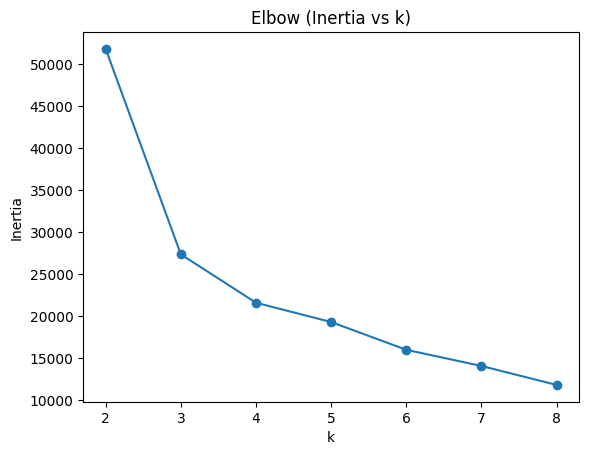

In [ ]:
# === Búsqueda de k ===
results = []
for k in CONFIG["k_candidates"]:
    km = KMeans(n_clusters=k, random_state=CONFIG["random_state"], n_init="auto")
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels) if k > 1 else np.nan
    dbi = davies_bouldin_score(X_scaled, labels) if k > 1 else np.nan
    inertia = km.inertia_
    results.append({"k": k, "silhouette": sil, "dbi": dbi, "inertia": inertia})

res = pd.DataFrame(results).sort_values("k")
print(res)

# curva elbow
try:
    from matplotlib import pyplot as plt
    ks = list(range(2, CONFIG["elbow_max_k"]+1))
    inertias = [] 
    for k in ks:
        km = KMeans(n_clusters=k, random_state=CONFIG["random_state"], n_init="auto").fit(X_scaled)
        inertias.append(km.inertia_)
    plt.figure(); plt.plot(ks, inertias, marker="o"); plt.title("Elbow (Inertia vs k)"); plt.xlabel("k"); plt.ylabel("Inertia"); plt.show()
except Exception as e:
    print("Plot elbow no crítico:", e)


In [ ]:
# === Fit final y renombrado ===
BEST_K = int(res.sort_values(["silhouette","dbi"], ascending=[False,True]).iloc[0]["k"])

km = KMeans(n_clusters=BEST_K, random_state=CONFIG["random_state"], n_init="auto")
feat["cluster_raw"] = km.fit_predict(X_scaled)

# Ordenar clusters por "intensidad" OUT (y empates por IN) para etiquetas legibles
order_key = (feat.groupby("cluster_raw")
               .agg(rank_key=("median_monthly_out","median"),
                    rank_key2=("median_monthly_in","median"))
               .sort_values(["rank_key","rank_key2"])
               .reset_index())
order_map = {raw:i for i, raw in enumerate(order_key["cluster_raw"])}
feat["cluster_ord"] = feat["cluster_raw"].map(order_map)

# Nombre amigable (IV-Low/Mid/High o IV-1/2/3)
label_names = {i: f"IV-{'Low' if i==0 else ('Mid' if i==1 else 'High')}" for i in range(BEST_K)}
feat["segment_label"] = feat["cluster_ord"].map(label_names)

print("k elegido:", BEST_K, "| distribución:", feat["segment_label"].value_counts(normalize=True).mul(100).round(1).to_dict())


k elegido: 2 | distribución: {'IV-Low': 99.9, 'IV-Mid': 0.1}


In [ ]:
# === Perfiles por subsegmento con medias y medianas ===
summary = (
    feat.groupby("segment_label", dropna=False)
        .agg(
            clients=("customer_id","nunique"),
            share_clients=("customer_id", lambda s: 100*s.nunique()/feat["customer_id"].nunique()),
            # OUT (intensidad y frecuencia)
            med_monthly_out=("median_monthly_out","median"),
            mean_monthly_out=("median_monthly_out","mean"),
            med_tx_month_out=("tx_per_active_month_out","median"),
            mean_tx_month_out=("tx_per_active_month_out","mean"),
            # IN
            med_monthly_in=("median_monthly_in","median"),
            mean_monthly_in=("median_monthly_in","mean"),
            med_tx_month_in=("tx_per_active_month_in","median"),
            mean_tx_month_in=("tx_per_active_month_in","mean"),
            # Ticket típico
            med_ticket_out=("median_amount_out","median"),
            mean_ticket_out=("median_amount_out","mean"),
            med_ticket_in=("median_amount_in","median"),
            mean_ticket_in=("median_amount_in","mean"),
        )
        .sort_values(["med_monthly_out","med_monthly_in"])
        .round(2)
)
display(summary)


,clients,share_clients,med_monthly_out,mean_monthly_out,med_tx_month_out,mean_tx_month_out,med_monthly_in,mean_monthly_in,med_tx_month_in,mean_tx_month_in,med_ticket_out,mean_ticket_out,med_ticket_in,mean_ticket_in
segment_label,,,,,,,,,,,,,,
IV-Low,2476,99.92,1.230479e+07,9.264971e+07,1.00,1.56,2.926562e+06,9.399929e+07,1.00,0.89,7.255533e+06,5.033069e+07,1.896969e+06,58124447.6
IV-Mid,2,0.08,1.887044e+10,1.887044e+10,8.75,8.75,1.515960e+10,1.515960e+10,17.62,17.62,1.316137e+09,1.316137e+09,8.428500e+08,842850000.0


In [ ]:
# === Celda 8 (nueva): Tabla única baseline vs segmentos + Δ y formateo ===

# 1) baseline (sin subsegmentar)
baseline = {
    "segment_label": "Baseline IV",
    "clients": feat["customer_id"].nunique(),
    "share_clients": 100.0,
    "med_monthly_out": feat["median_monthly_out"].median(),
    "mean_monthly_out": feat["median_monthly_out"].mean(),
    "med_tx_month_out": feat["tx_per_active_month_out"].median(),
    "mean_tx_month_out": feat["tx_per_active_month_out"].mean(),
    "med_monthly_in": feat["median_monthly_in"].median(),
    "mean_monthly_in": feat["median_monthly_in"].mean(),
    "med_tx_month_in": feat["tx_per_active_month_in"].median(),
    "mean_tx_month_in": feat["tx_per_active_month_in"].mean(),
    "med_ticket_out": feat["median_amount_out"].median(),
    "mean_ticket_out": feat["median_amount_out"].mean(),
    "med_ticket_in": feat["median_amount_in"].median(),
    "mean_ticket_in": feat["median_amount_in"].mean(),
}
baseline_df = pd.DataFrame([baseline]).set_index("segment_label")

# 2) unir baseline con los segmentos
summary2 = summary.copy()
summary2.index.name = "segment_label"
summary_all = pd.concat([baseline_df, summary2], axis=0)

# 3) calcular Δ vs baseline para filas de segmentos
delta_cols = [
    "med_monthly_out","mean_monthly_out","med_tx_month_out","mean_tx_month_out",
    "med_monthly_in","mean_monthly_in","med_tx_month_in","mean_tx_month_in",
    "med_ticket_out","mean_ticket_out","med_ticket_in","mean_ticket_in"
]
for c in delta_cols:
    summary_all[f"Δ_{c}"] = summary_all[c] - summary_all.loc["Baseline IV", c]

# 4) reordenar columnas (bloques: OUT, IN, Ticket)
ordered_cols = [
    "clients","share_clients",
    # OUT
    "med_monthly_out","mean_monthly_out","med_tx_month_out","mean_tx_month_out",
    # IN
    "med_monthly_in","mean_monthly_in","med_tx_month_in","mean_tx_month_in",
    # Ticket
    "med_ticket_out","mean_ticket_out","med_ticket_in","mean_ticket_in",
]
summary_all = summary_all.reindex(columns=ordered_cols)

# 5) formateo: CLP con separador de miles; frecuencias con 2 decimales; %
def fmt_amount(x):   # montos CLP
    try:
        return f"{float(x):,.0f}"
    except Exception:
        return x

def fmt_freq(x):     # tx/mes
    try:
        return f"{float(x):,.2f}"
    except Exception:
        return x

def fmt_pct(x):      # %
    try:
        return f"{float(x):.2f}%"
    except Exception:
        return x

amount_cols = [
    "med_monthly_out","mean_monthly_out","med_monthly_in","mean_monthly_in",
    "med_ticket_out","mean_ticket_out","med_ticket_in","mean_ticket_in",
]
freq_cols = [
    "med_tx_month_out","mean_tx_month_out","med_tx_month_in","mean_tx_month_in",
]

summary_fmt = summary_all.copy()
summary_fmt["share_clients"] = summary_fmt["share_clients"].map(fmt_pct)
for c in amount_cols:
    summary_fmt[c] = summary_fmt[c].map(fmt_amount)
for c in freq_cols:
    summary_fmt[c] = summary_fmt[c].map(fmt_freq)

# 6) ordenar filas: Baseline, IV-Low, IV-Mid (si existen)
row_order = [r for r in ["Baseline IV","IV-Low","IV-Mid","IV-High"] if r in summary_fmt.index]
summary_fmt = summary_fmt.loc[row_order]

display(summary_fmt)


,clients,share_clients,med_monthly_out,mean_monthly_out,med_tx_month_out,mean_tx_month_out,med_monthly_in,mean_monthly_in,med_tx_month_in,mean_tx_month_in,med_ticket_out,mean_ticket_out,med_ticket_in,mean_ticket_in
segment_label,,,,,,,,,,,,,,
Baseline IV,2478,100.00%,"12,327,772","107,805,316",1.00,1.57,"2,974,078","106,158,775",1.00,0.90,"7,302,154","51,352,326","1,898,884","58,757,802"
IV-Low,2476,99.92%,"12,304,788","92,649,713",1.00,1.56,"2,926,562","93,999,291",1.00,0.89,"7,255,533","50,330,691","1,896,969","58,124,448"
IV-Mid,2,0.08%,"18,870,441,882","18,870,441,882",8.75,8.75,"15,159,600,000","15,159,600,000",17.62,17.62,"1,316,136,912","1,316,136,912","842,850,000","842,850,000"


: 

In [10]:
# === Celda 9: Export etiquetas IV ===
export_cols = [
    "customer_id","customer_name","segment_label",
    # OUT
    "median_monthly_out","tx_per_active_month_out","median_amount_out",
    # IN
    "median_monthly_in","tx_per_active_month_in","median_amount_in",
    # Fechas
    "first_tx","last_tx"
]
feat[export_cols].to_csv(CONFIG["paths"]["export_segments"], index=False, encoding="utf-8-sig")
print("Exportado a:", CONFIG["paths"]["export_segments"])


Exportado a: ../../data/iv_segments.csv


In [11]:
# === A1: identificar el micro-cluster y ver métricas ===
tiny_seg = feat.query("segment_label == 'IV-Mid'").copy()
display(tiny_seg[[
    "customer_id","customer_name",
    "median_monthly_out","tx_per_active_month_out",
    "median_monthly_in","tx_per_active_month_in",
    "median_amount_out","median_amount_in",
    "first_tx","last_tx"
]].sort_values("median_monthly_out", ascending=False))

print("Participación en transacciones OUT/IN del micro-cluster:")
cid = tiny_seg["customer_id"].tolist()
agg_total = tx.groupby("tx_direction")["tx_base_amount"].sum().rename("total")
agg_tiny  = tx[tx["customer_id"].isin(cid)].groupby("tx_direction")["tx_base_amount"].sum().rename("tiny")
display(pd.concat([agg_total, agg_tiny], axis=1).assign(share=lambda d: 100*d["tiny"]/d["total"]))


,customer_id,customer_name,median_monthly_out,tx_per_active_month_out,median_monthly_in,tx_per_active_month_in,median_amount_out,median_amount_in,first_tx,last_tx
2248,94727000.0,GTD GRUPO TELEDUCTOS S.A.,2.273480e+10,7.5,1.929950e+10,8.25,1.560919e+09,1.500000e+09,2025-04-08,2025-08-27
2188,82606800.0,CAJA DE COMPENSACION 18 DE SEPTIEMBRE,1.500609e+10,10.0,1.101970e+10,27.00,1.071355e+09,1.857000e+08,2025-03-03,2025-08-26


Participación en transacciones OUT/IN del micro-cluster:


,total,tiny,share
tx_direction,,,
Inbound,8.309666e+11,1.392023e+11,16.751852
Outbound,9.722447e+11,1.593551e+11,16.390430


In [12]:
# === A2: cruce con alertas por cliente y por regla ===
al = pd.read_csv(CONFIG["paths"]["alerts_csv"], encoding="utf-8-sig")
al.columns = _clean_headers(al.columns)
al["status"] = al["status"].astype(str).str.strip()
al["is_tp"]  = (al["status"].str.upper() == "SUSPICIOUS").astype(int)

# join por customer_id (si tienes tx_id, mejor, pero para “foto por cliente” alcanza)
al_iv = al[al["customer_sub_type"].str.upper().eq(CONFIG["iv_label"].upper())].copy()
al_iv_tiny = al_iv[al_iv["subject_ids"].astype(str).isin(cid) | al_iv["subject_names"].astype(str).isin(tiny_seg["customer_name"])]

print("Alertas del micro-cluster (total, TP, FP):", 
      len(al_iv_tiny), al_iv_tiny["is_tp"].sum(), len(al_iv_tiny)-al_iv_tiny["is_tp"].sum())

# reglas top en el micro-cluster
piv_tiny = (al_iv_tiny.groupby(["rule_code","tx_direction"], dropna=False)
                     .agg(alerts=("alert_id","nunique"),
                          tp=("is_tp","sum"))
                     .reset_index())
piv_tiny["fp"] = piv_tiny["alerts"] - piv_tiny["tp"]
display(piv_tiny.sort_values("alerts", ascending=False).head(20))

# comparación con resto IV
rest_cids = set(feat["customer_id"]) - set(cid)
al_iv_rest = al_iv[~al_iv["subject_ids"].astype(str).isin(cid)]
piv_rest = (al_iv_rest.groupby(["rule_code","tx_direction"], dropna=False)
                       .agg(alerts=("alert_id","nunique"),
                            tp=("is_tp","sum"))
                       .reset_index())
piv_rest["fp"] = piv_rest["alerts"] - piv_rest["tp"]
display(piv_rest.sort_values("alerts", ascending=False).head(20))


Alertas del micro-cluster (total, TP, FP): 41 0 41


,rule_code,tx_direction,alerts,tp,fp
15,PGAV-OUT,Outbound,8,0,8
1,HASUMI,Inbound,7,0,7
11,P-LBAL,Inbound,4,0,4
12,P-TLI,Inbound,4,0,4
10,P-HSUMO,Outbound,3,0,3
6,OUT>%IN,Outbound,2,0,2
5,OUT>%IN,Inbound,2,0,2
4,IN>%OUT,Inbound,2,0,2
13,P-TLO,Outbound,2,0,2
0,HANUMI,Inbound,1,0,1


,rule_code,tx_direction,alerts,tp,fp
29,P-LVAL,Inbound,21,2,19
34,PGAV-OUT,Outbound,18,0,18
6,HANUMI,Inbound,11,1,10
18,NCU,Outbound,10,1,9
30,P-LVAL,Outbound,10,1,9
8,HASUMI,Inbound,10,0,10
9,HASUMO,Outbound,9,0,9
7,HANUMO,Outbound,9,1,8
27,P-HSUMO,Outbound,8,0,8
32,P-TLO,Outbound,8,0,8
